In [1]:
import local.lib.timeseries as ts
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## we have an example time series with three signals

In [2]:
idx = pd.date_range("2018-01-01", "2018-03-31", freq="1d")
x0 = np.sin(np.linspace(0,6,len(idx)))+np.random.normal(size=len(idx))*.1
x1 = np.sin(np.linspace(1,12,len(idx)))+np.random.normal(size=len(idx))*.1
t  = np.cos(.5*np.linspace(-5,4,len(idx)))+np.random.normal(size=len(idx))*.1
d = pd.DataFrame(np.r_[[x0,x1, t]].T, 
                 columns=["potus", "sup", "target"], index=idx) 
d.head()


,potus,sup,target
2018-01-01,-0.138305,0.949002,-0.867837
2018-01-02,0.117833,0.742308,-0.666024
2018-01-03,0.193309,0.862322,-0.705278
2018-01-04,0.085521,1.060751,-0.685009
2018-01-05,0.448056,1.038446,-0.658672


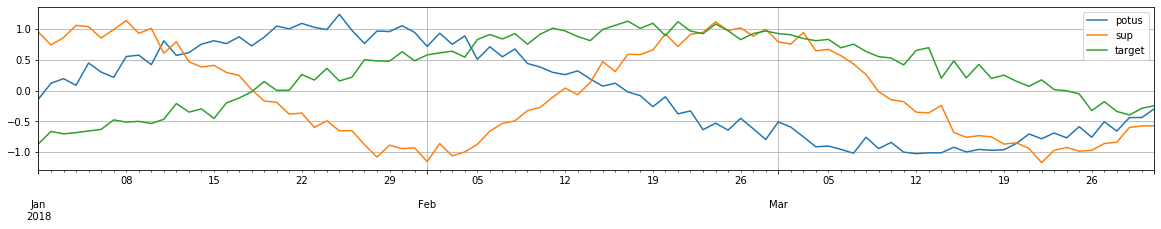

In [3]:
d.plot(figsize=(20,3))
plt.grid();

## we want to predict `target` with the information of `potus` and `sup` available in the SAME time instant PLUS the ones available in the previous two time instants

### first we build a timeseries dataset from the previous three signals (lookback)

observe how values are duplicated from one column to the next one

In [4]:
from importlib import reload
reload(ts)

dt = ts.timeseries_as_many2one(d, columns=["sup", "potus"], nb_timesteps_in=2)

In [5]:
dt.head()

,sup_0,sup_1,potus_0,potus_1,potus,sup,target
2018-01-04,0.949002,0.742308,-0.138305,0.117833,0.085521,1.060751,-0.685009
2018-01-05,0.742308,0.862322,0.117833,0.193309,0.448056,1.038446,-0.658672
2018-01-06,0.862322,1.060751,0.193309,0.085521,0.300660,0.855835,-0.631737
2018-01-07,1.060751,1.038446,0.085521,0.448056,0.215416,0.992852,-0.478122
2018-01-08,1.038446,0.855835,0.448056,0.300660,0.553775,1.139357,-0.513941


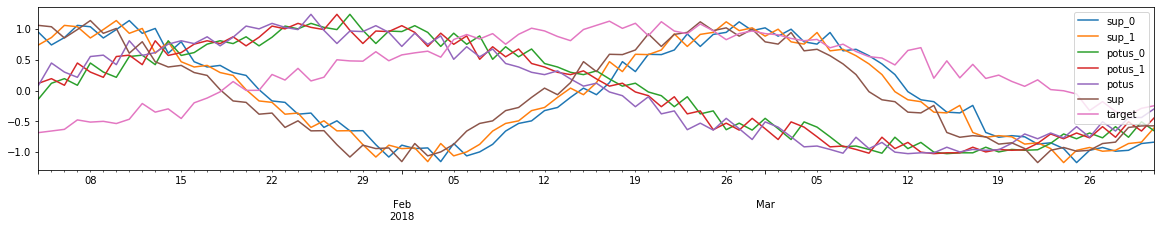

In [6]:
dt.plot(figsize=(20,3))

## we want to test a model on the dataset a just created

- we train on 20 days
- test on the following 5 days
- move both windows by 5 days, and repeat

In [7]:
from sklearn.metrics import mean_squared_error
from importlib import reload
reload(ts)
tse = ts.Timeseries_Experiment(dt, train_period="20d", test_period="5d", metrics_funcs=["rmse"], target_col="target")

observe how folds are created

In [8]:
tse.print_folds_info()

experiment has 14 time based folds
------------------------------------
train start           train end             test start            test end
2018-01-04 00:00  --  2018-01-23 23:59      2018-01-24 00:00  --  2018-01-28 23:59
2018-01-09 00:00  --  2018-01-28 23:59      2018-01-29 00:00  --  2018-02-02 23:59
2018-01-12 00:00  --  2018-02-02 23:59      2018-02-03 00:00  --  2018-02-07 23:59
2018-01-19 00:00  --  2018-02-07 23:59      2018-02-08 00:00  --  2018-02-12 23:59
2018-01-24 00:00  --  2018-02-12 23:59      2018-02-13 00:00  --  2018-02-17 23:59
2018-01-29 00:00  --  2018-02-17 23:59      2018-02-18 00:00  --  2018-02-22 23:59
2018-02-02 00:00  --  2018-02-22 23:59      2018-02-23 00:00  --  2018-02-27 23:59
2018-02-08 00:00  --  2018-02-27 23:59      2018-02-28 00:00  --  2018-03-04 23:59
2018-02-13 00:00  --  2018-03-04 23:59      2018-03-05 00:00  --  2018-03-09 23:59
2018-02-16 00:00  --  2018-03-09 23:59      2018-03-10 00:00  --  2018-03-14 23:59
2018-02-23 00:00  --  2

we choose a ML method and train. observe that training is parallelized

In [9]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(n_jobs=1)
tse.set_estimator(estimator)

In [10]:
tse.run()

 [mParallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    1.4s finishedg:    0.0s

## we can inspect all predections

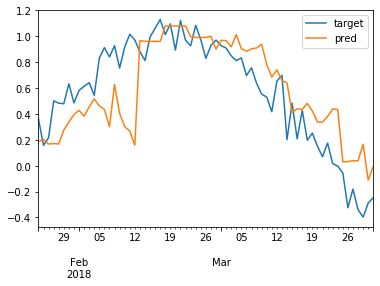

In [11]:
tse.results_test.details.plot()

## or aggregate metrics by different time period criteria

In [13]:
tse.results_test.get_metrics(resampling_period="10d")

,count,rmse
2018-01-24,10,0.214049
2018-02-03,10,0.499889
2018-02-13,10,0.110612
2018-02-23,10,0.100394
2018-03-05,10,0.249338
2018-03-15,10,0.262149
2018-03-25,7,0.322989


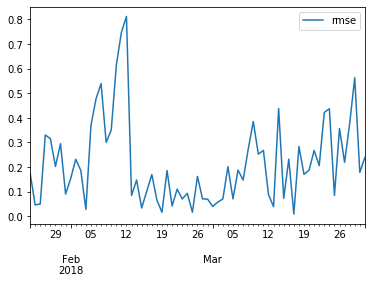

In [15]:
tse.results_test.get_metrics(resampling_period="1d")[["rmse"]].plot()
